# NASA Turbofan Jet Engine

https://www.kaggle.com/datasets/behrad3d/nasa-cmaps  
참고 링크  
https://towardsdatascience.com/predictive-maintenance-of-turbofan-engines-ec54a083127

![데이터 개요](https://miro.medium.com/max/1100/1*73ADCKv2i0Dev-jJSA2jIg.webp)

- 1열 : 엔진 번호  
- 2열 : 사이클 횟수  
(만약 엔진1이 192사이클 후에 고장났다면,  엔진 1의 2열 값이 1부터 192까지 있는 행이 존재하게 됨)  
- 3,4,5열 : 작동 설정  
- 6~26열 : 센서값  

## 0. 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 불러오기

In [4]:
train_no_name = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test_no_name = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
y_test_no_name = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

In [5]:
train_no_name.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...      16       17       18      19    20   21    22     23     24  \
0  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

        25  
0  23.4190  
1  23.4236  
2  23.3442  
3  23.3739  
4  23.4044  

[5 rows x 26 columns]

열에 이름 붙이기

In [6]:
columns = {0:'engineNumber', 1:'cycleTime',
            2:'opSetting1', 3:'opSetting2', 4:'opSetting3',
            5:'sensor1', 6:'sensor2',
            7:'sensor3', 8:'sensor4', 9:'sensor5', 10:'sensor6', 11:'sensor7', 12:'sensor8', 13:'sensor9', 14:'sensor10',
            15:'sensor11', 16:'sensor12', 17:'sensor13', 18:'sensor14', 19:'sensor15', 20:'sensor16',
            21:'sensor17', 22:'sensor18', 23:'sensor19', 24:'sensor20', 25:'sensor21'}

In [7]:
train_modi = train_no_name.rename(columns=columns)
test = test_no_name.rename(columns=columns)
y_test = y_test_no_name.rename(columns={0: 'RUL'})

## 2. 데이터 탐색 & 전처리

In [8]:
train_modi.describe()

engineNumber     cycleTime    opSetting1    opSetting2  opSetting3  \
count  20631.000000  20631.000000  20631.000000  20631.000000     20631.0   
mean      51.506568    108.807862     -0.000009      0.000002       100.0   
std       29.227633     68.880990      0.002187      0.000293         0.0   
min        1.000000      1.000000     -0.008700     -0.000600       100.0   
25%       26.000000     52.000000     -0.001500     -0.000200       100.0   
50%       52.000000    104.000000      0.000000      0.000000       100.0   
75%       77.000000    156.000000      0.001500      0.000300       100.0   
max      100.000000    362.000000      0.008700      0.000600       100.0   

            sensor1       sensor2       sensor3       sensor4       sensor5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150      9.000605  3.394700e-12   
min    5.186700e+02    641.210000   1571.040000   1382.250000  1.462000e+01   
25%    5.186700e+02    642.325000   1586.260000   1402.360000  1.462000e+01   
50%    5.186700e+02    642.640000   1590.100000   1408.040000  1.462000e+01   
75%    5.186700e+02    643.000000   1594.380000   1414.555000  1.462000e+01   
max    5.186700e+02    644.530000   1616.910000   1441.490000  1.462000e+01   

       ...      sensor12      sensor13      sensor14      sensor15  \
count  ...  20631.000000  20631.000000  20631.000000  20631.000000   
mean   ...    521.413470   2388.096152   8143.752722      8.442146   
std    ...      0.737553      0.071919     19.076176      0.037505   
min    ...    518.690000   2387.880000   8099.940000      8.324900   
25%    ...    520.960000   2388.040000   8133.245000      8.414900   
50%    ...    521.480000   2388.090000   8140.540000      8.438900   
75%    ...    521.950000   2388.140000   8148.310000      8.465600   
max    ...    523.380000   2388.560000   8293.720000      8.584800   

           sensor16      sensor17  sensor18  sensor19      sensor20  \
count  2.063100e+04  20631.000000   20631.0   20631.0  20631.000000   
mean   3.000000e-02    393.210654    2388.0     100.0     38.816271   
std    1.556432e-14      1.548763       0.0       0.0      0.180746   
min    3.000000e-02    388.000000    2388.0     100.0     38.140000   
25%    3.000000e-02    392.000000    2388.0     100.0     38.700000   
50%    3.000000e-02    393.000000    2388.0     100.0     38.830000   
75%    3.000000e-02    394.000000    2388.0     100.0     38.950000   
max    3.000000e-02    400.000000    2388.0     100.0     39.430000   

           sensor21  
count  20631.000000  
mean      23.289705  
std        0.108251  
min       22.894200  
25%       23.221800  
50%       23.297900  
75%       23.366800  
max       23.618400  

[8 rows x 26 columns]

In [9]:
# 엔진 개수
num_machines = np.unique(train_modi['engineNumber']).shape[0]
num_machines

100

In [10]:
# 몇 번의 사이클 후에 엔진이 고장나는가?
num_cycles_to_failure = train_modi.groupby('engineNumber')['cycleTime'].count()
num_cycles_to_failure[:10]

engineNumber
1     192
2     287
3     179
4     189
5     269
6     188
7     259
8     150
9     201
10    222
Name: cycleTime, dtype: int64

In [11]:
# 엔진에 따른 사이클 값 - 작동설정 값의 분포
train_modi.groupby('engineNumber').max().describe().iloc[:, :4]

cycleTime  opSetting1  opSetting2  opSetting3
count  100.000000  100.000000  100.000000       100.0
mean   206.310000    0.005986    0.000497       100.0
std     46.342749    0.000883    0.000056         0.0
min    128.000000    0.004000    0.000400       100.0
25%    177.000000    0.005375    0.000500       100.0
50%    199.000000    0.005900    0.000500       100.0
75%    229.250000    0.006425    0.000500       100.0
max    362.000000    0.008700    0.000600       100.0

In [12]:
train_modi.loc[:,'sensor1':'sensor21'].describe().transpose()
# 1, 10, 18, 19번
# 5, 6, 16번 변동 적음 -> 자세하게 알아볼 필요가 있음

count         mean           std        min        25%        50%  \
sensor1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
sensor2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
sensor3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
sensor4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
sensor5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
sensor6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
sensor7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
sensor8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
sensor9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
sensor10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
sensor11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
sensor12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
sensor13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
sensor14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
sensor15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
sensor16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
sensor17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
sensor18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
sensor19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
sensor20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
sensor21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

                75%        max  
sensor1    518.6700   518.6700  
sensor2    643.0000   644.5300  
sensor3   1594.3800  1616.9100  
sensor4   1414.5550  1441.4900  
sensor5     14.6200    14.6200  
sensor6     21.6100    21.6100  
sensor7    554.0100   556.0600  
sensor8   2388.1400  2388.5600  
sensor9   9069.4200  9244.5900  
sensor10     1.3000     1.3000  
sensor11    47.7000    48.5300  
sensor12   521.9500   523.3800  
sensor13  2388.1400  2388.5600  
sensor14  8148.3100  8293.7200  
sensor15     8.4656     8.5848  
sensor16     0.0300     0.0300  
sensor17   394.0000   400.0000  
sensor18  2388.0000  2388.0000  
sensor19   100.0000   100.0000  
sensor20    38.9500    39.4300  
sensor21    23.3668    23.6184

### Boxplots of sensor data
sensor6 ~ sensor 21까지 Boxplot으로 확인  

describe와 시각화를 통해 1, 10, 18, 19번은 값의 변동이 없음을 알 수 있음  

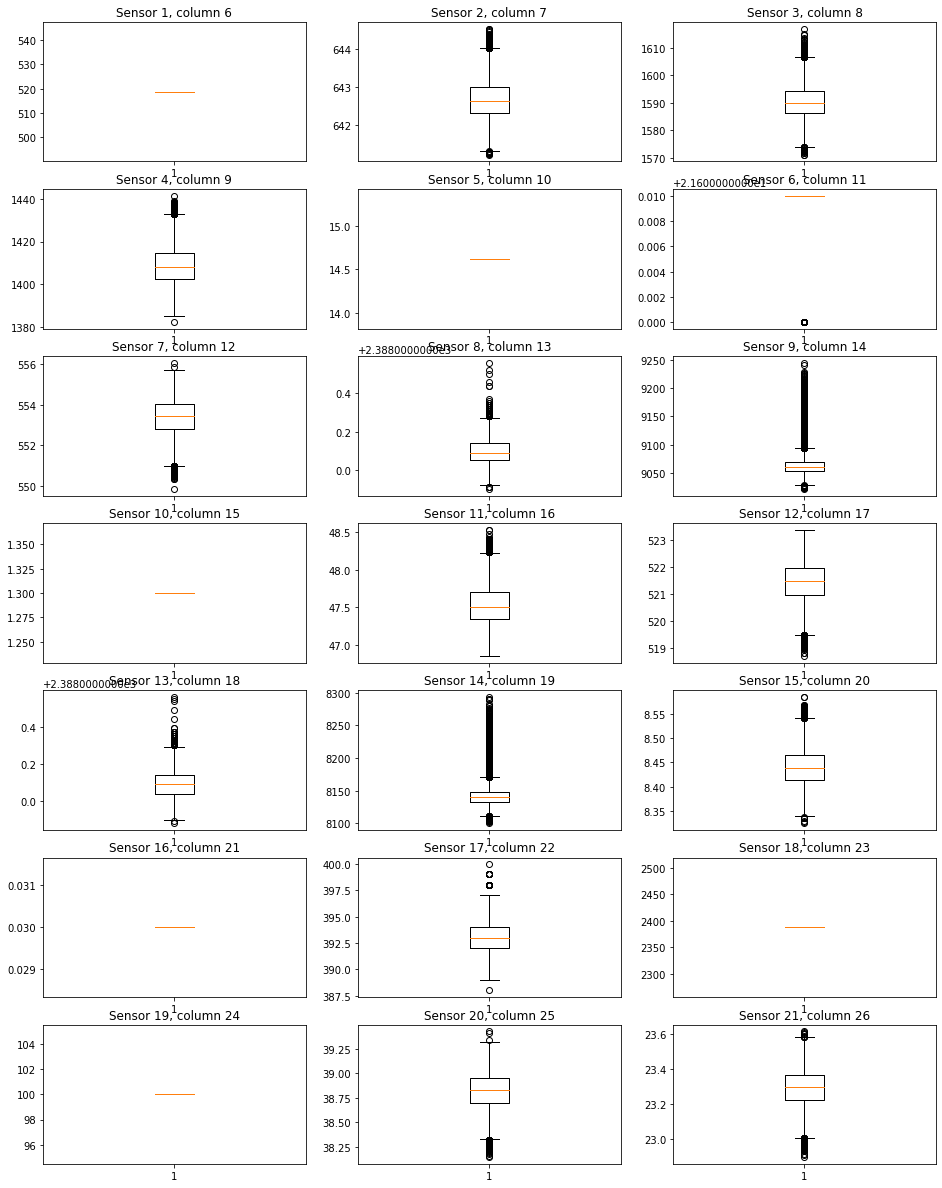

In [13]:
plt.figure(figsize = (16, 21))

for i in range(21):
    temp_data = train_modi.iloc[:,i+5]  # 5번 인덱스부터 25번 인덱스 (sensor6 ~ sensor21)
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
    plt.title("Sensor " + str(i+1) + ", column "+ str(i+6))
plt.show()

### train의 RUL 추정
가정 : 시간이 지남에 따라 선형적으로 감소하고 엔진의 마지막 타임 사이클에서 값이 0이라고 가정  
EX) 엔진이 고장 전 10 사이클에서 RUL이 10이 되고, 엔진이 고장 전 50에서 사이클에서 50이 됨

RUL = cycleTime의 최댓값 - cycleTime

* RUL(Remaining Useful Life)
    * 잔여 수명

In [14]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="engineNumber")
    max_cycle = grouped_by_unit["cycleTime"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='maxCycle'), left_on='engineNumber', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["maxCycle"] - result_frame["cycleTime"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("maxCycle", axis=1)
    return result_frame
  
train_modi = add_remaining_useful_life(train_modi)
train_modi[['engineNumber', 'cycleTime', 'RUL']].head()

engineNumber  cycleTime  RUL
0             1          1  191
1             1          2  190
2             1          3  189
3             1          4  188
4             1          5  187

#### 히스토그램으로 RUL 분포 확인

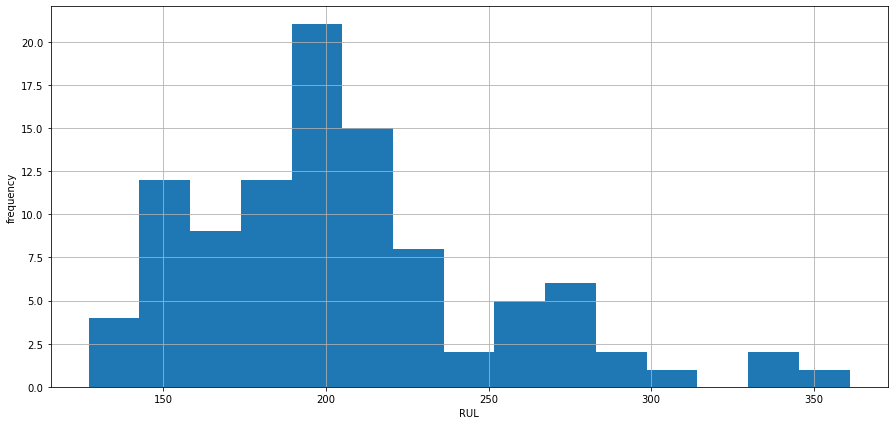

In [15]:
df_max_rul = train_modi[['engineNumber', 'RUL']].groupby('engineNumber').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

# 200사이클 정도에서 엔진의 고장이 잦음을 알 수 있음
# 데이터가 쏠려있고 300사이클 이상 지속되는 엔진은 거의 없음

#### 10개 간격으로 엔진의 RUL에 따른 센서 값 확인

In [16]:
# 10, 20, ... 100번 엔진의 RUL에 따른 센서 값 
def plot_sensor(sensor_names):
    plt.figure(figsize=(25,25))
    for idx, sensor_name in enumerate(sensor_names):
        plt.subplot(7, 3, idx+1)
        for i in train_modi['engineNumber'].unique():
            if (i % 10 == 0):  # only plot every 10th engineNumber
                plt.plot('RUL', sensor_name, data=train_modi[train_modi['engineNumber']==i])
                plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
                plt.xticks(np.arange(0, 275, 25))
                plt.ylabel(sensor_name)
                plt.xlabel('Remaining Use fulLife')
    plt.show()

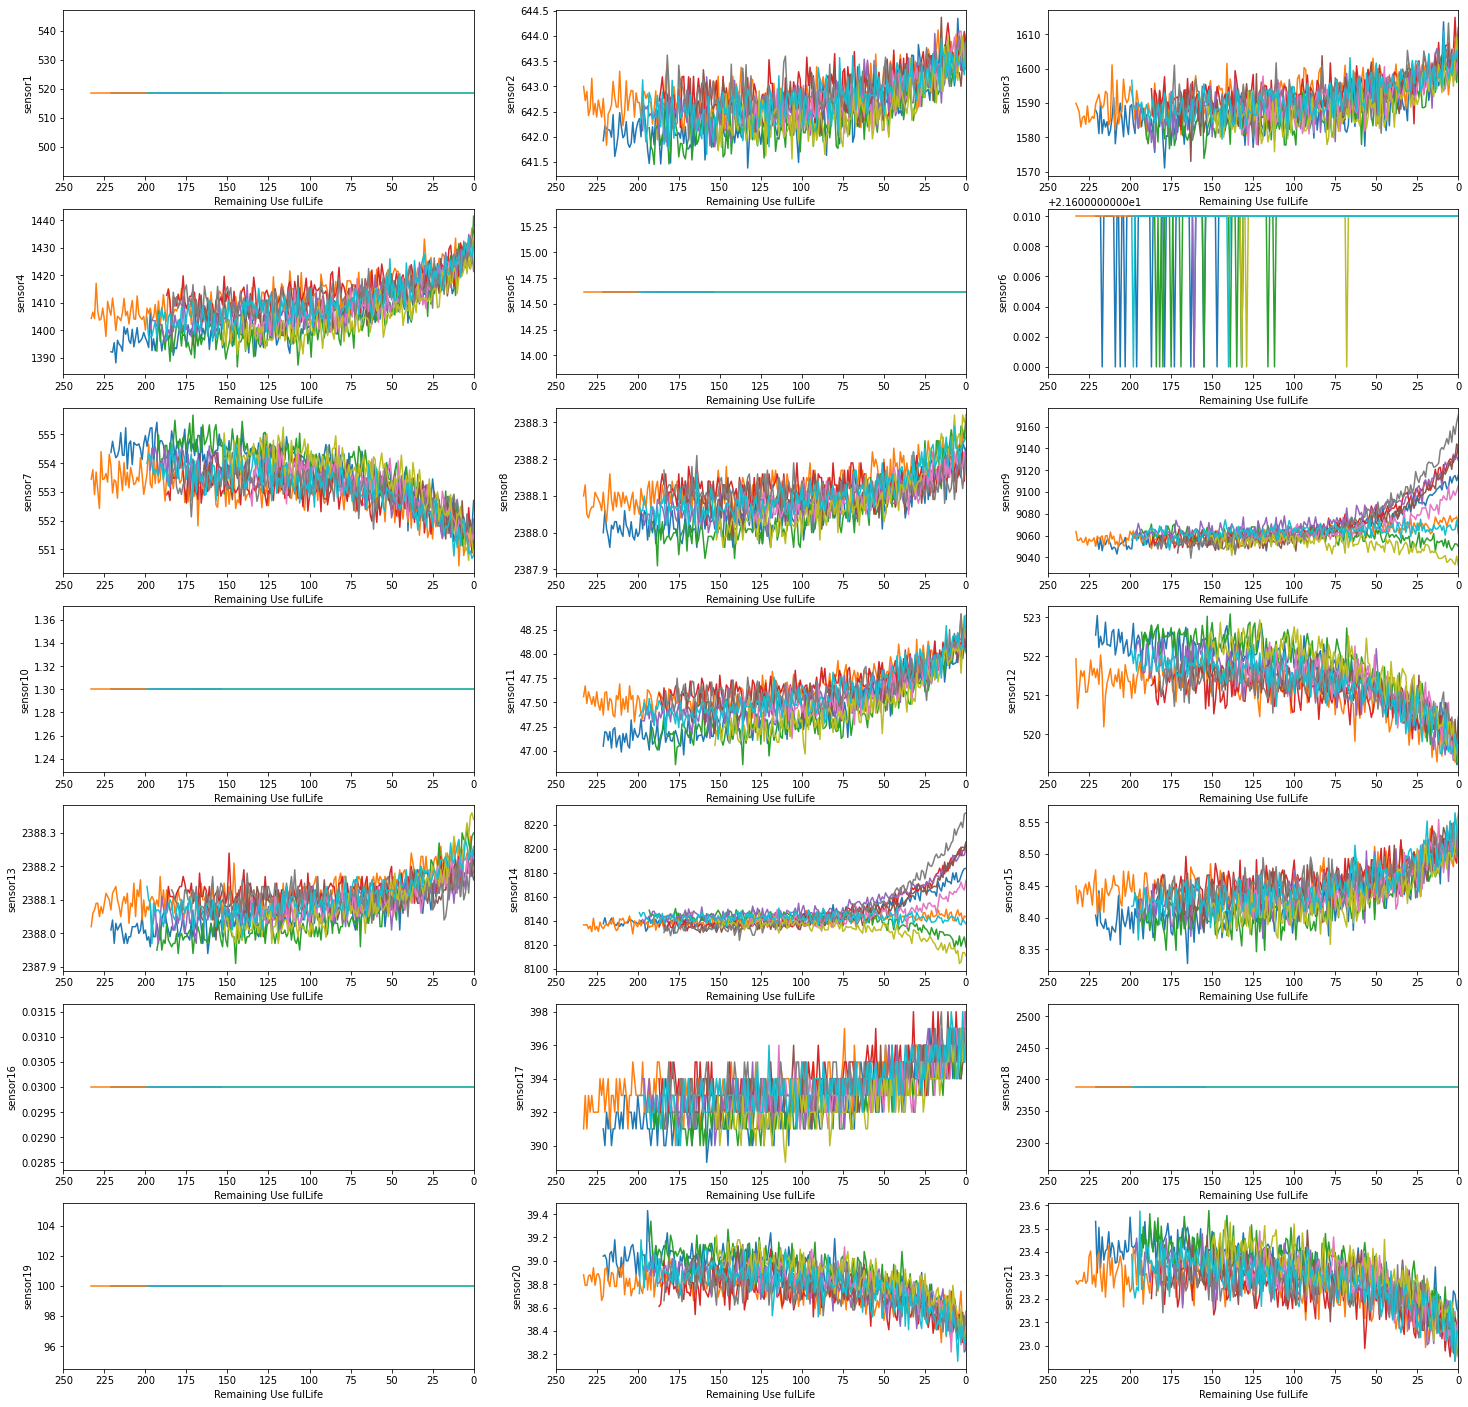

In [17]:
plot_sensor(train_modi.columns[5:-1])

sensor1, 10, 18, 19 : flat line 및 기술통계량에 의해 제거하자  
sensor5, 16 : flat line => 변화량이 적은 변수 -> 제거하자  
sensor2, 3, 4, 8, 11, 13, 15, 17 => 증가  
sensor7, 12, 20, 21 => 감소  
sensor6 => RUL과 뚜렷한 관계가 보이지 않음  
sensor9, 14 => 비슷한 모습

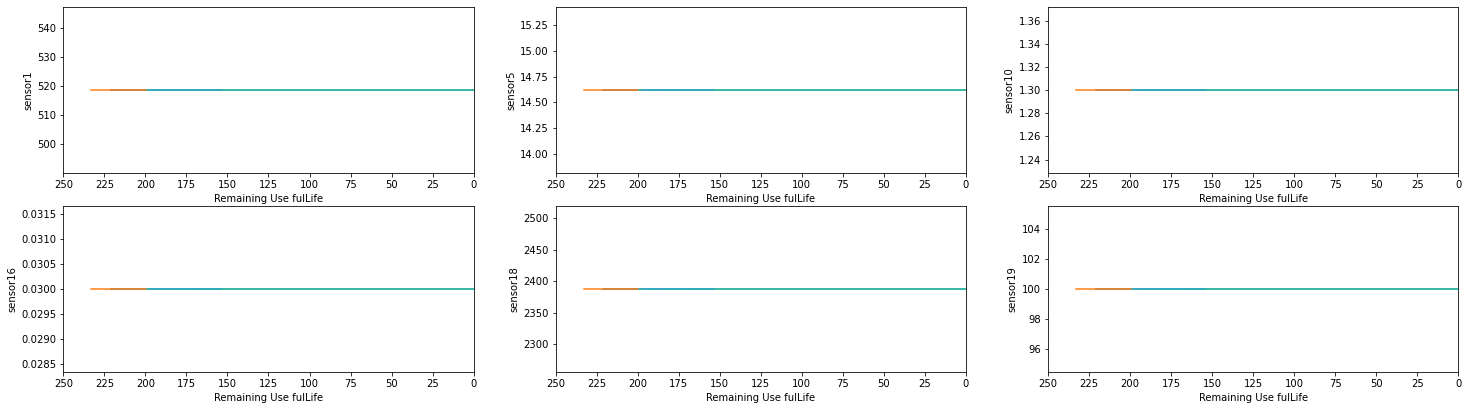

In [18]:
flat_sensor = [f'sensor{i}' for i in [1, 5, 10, 16, 18, 19]]
plot_sensor(flat_sensor)

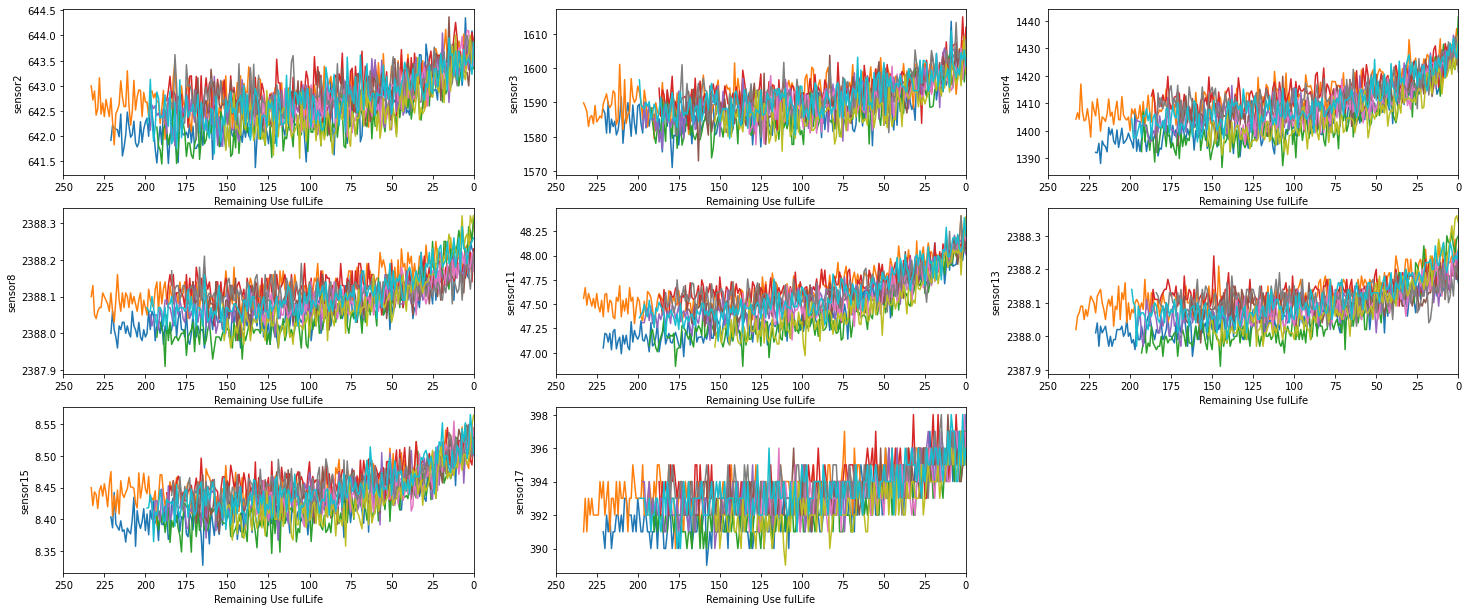

In [19]:
increasing_sensor = [f'sensor{i}' for i in [2, 3 ,4, 8, 11, 13, 15, 17]]
plot_sensor(increasing_sensor)

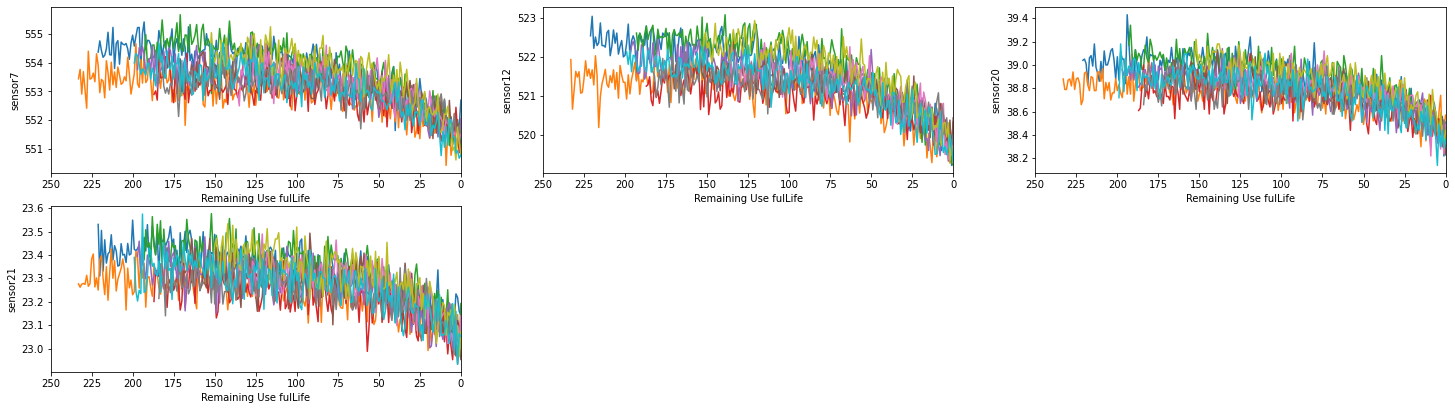

In [20]:
decreasing_sensor = [f'sensor{i}' for i in [7, 12, 20, 21]]
plot_sensor(decreasing_sensor)

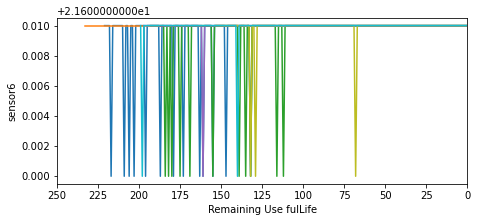

In [21]:
plot_sensor(['sensor6'])

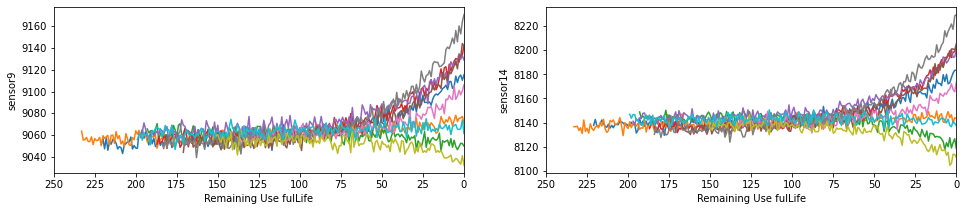

In [22]:
plot_sensor(['sensor9', 'sensor14'])

## 5. 모델링 및 학습

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

학습과 무관한 engineNumber, cycleTime, opSetting1, 2, 3,
sensor 1, 5, 6, 10, 16, 18, 19 값을 버리기로 결정

In [24]:
drop_labels=['engineNumber', 'cycleTime', 
            'opSetting1', 'opSetting2', 'opSetting3',
            'sensor1','sensor5','sensor6','sensor10','sensor16','sensor18', 'sensor19']

In [25]:
X_train = train_modi.drop(columns=drop_labels, axis=1)
y_train = X_train.pop('RUL')
X_test = test.groupby('engineNumber').last().reset_index().drop(drop_labels, axis=1)

### RSME

In [26]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [27]:
linear = LinearRegression()
linear.fit(X_train, y_train)

y_hat_train = linear.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = linear.predict(X_test)
evaluate(y_test, y_hat_test)

# train set보다 test set의 RMSE 값이 더 낮다?
# 문제가 있다..
# 이유는 선형적으로 추정한 RUL 값 때문

train set RMSE:44.66819159545419, R2:0.579448652779678
test set RMSE:31.952633027740525, R2:0.4087736807657887


In [28]:
y_hat_test = pd.DataFrame(y_hat_test)
y_test = y_test.reset_index(drop=True)
comp_df = pd.concat([y_test,y_hat_test], axis=1)
comp_df.columns = ["actual","predict"]

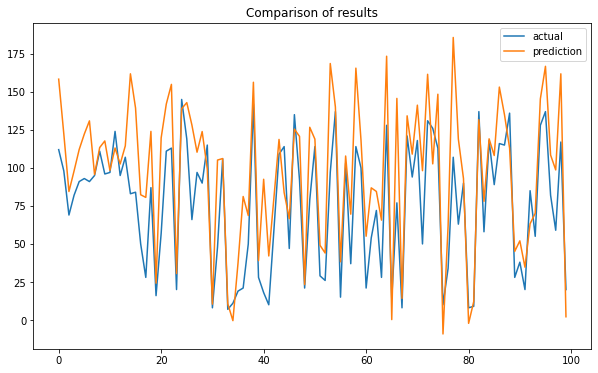

In [29]:
plt.figure(figsize=(10,6))
plt.title('Comparison of results')
plt.plot(comp_df)
plt.legend(['actual', 'prediction']);

참고 링크  
https://towardsdatascience.com/the-importance-of-problem-framing-for-supervised-predictive-maintenance-solutions-cc8646826093

센서의 값이 일정하다가 감소하는 것을 볼 수 있음
-> 엔진이 시간이 지남에 따라 고장 발생하기 때문

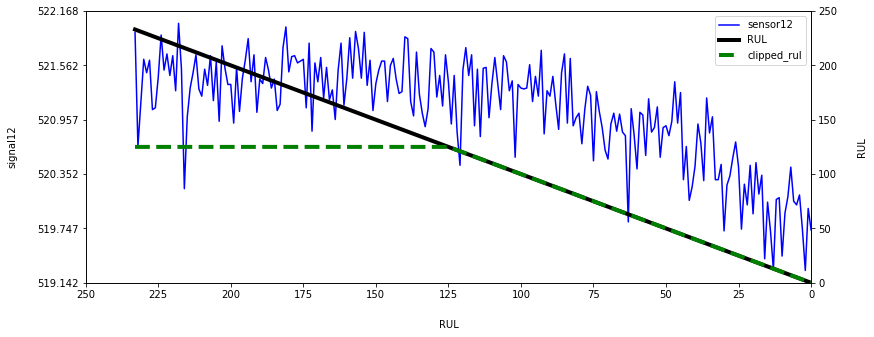

In [30]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot('RUL', 'sensor12', 'b',
                 data=train_modi.loc[train_modi['engineNumber']==20])
plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('signal12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot('RUL', 'RUL', 'k', linewidth=4,
                   data=train_modi.loc[train_modi['engineNumber']==20])
rul = train_modi.loc[train_modi['engineNumber']==20, 'RUL']
rul_line2 = ax2.plot(rul, rul.where(rul <= 125, 125), '--g', linewidth=4, label='clipped_rul')  # SET LABEL MANUALLY?
ax2.set_ylabel('RUL', labelpad=20)

# code to have equal spacing of y ticks for both axes, so the gridlines allign
# from https://stackoverflow.com/questions/20243683/matplotlib-align-twinx-tick-marks?rq=1
ax2.set_ylim(0, 250)  # set limits of axis you want to display neatly
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))  # choose integer to neatly divide your axis, in our case 6
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))  # apply same spacing to other axis


# code to have a unified legend
# from https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = signal+rul_line+rul_line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)

plt.show()

#### 성능 향상

In [31]:
y_train_clipped = y_train.clip(upper=125)

# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.491018701514854, R2:0.7340432868050586
test set RMSE:21.900213406894117, R2:0.7222608196545328


In [32]:
y_hat_test = pd.DataFrame(y_hat_test)
y_test = y_test.reset_index(drop=True)
comp_df = pd.concat([y_test,y_hat_test], axis=1)
comp_df.columns = ["actual","predict"]

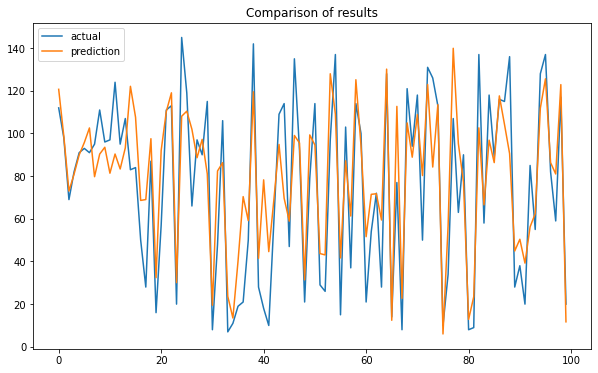

In [33]:
plt.figure(figsize=(10,6))
plt.title('Comparison of results')
plt.plot(comp_df)
plt.legend(['actual', 'prediction']);